In [1]:
import os
import cv2
import gdcm
import pydicom
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from dicom2stl.examples import gui
from dicom2stl.utils import vtkutils
from dicom2stl.examples.myshow import myshow, myshow3d

from pydicom import dcmread
from pydicom.data import get_testdata_file
from pydicom.uid import ExplicitVRLittleEndian

from skimage import feature, filters
from skimage.filters import roberts, sobel, scharr, prewitt

from scipy import ndimage
from PIL import Image, ImageFilter

import itkwidgets

%load_ext autoreload
%autoreload 1

In [2]:
%matplotlib notebook

## Original Images

In [3]:
path = "pos_twist_05iso_37"

In [4]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(path)
reader.SetFileNames(dicom_names)
original_image = reader.Execute()

size = original_image.GetSize()
size

(192, 512, 120)

<IPython.core.display.Javascript object>


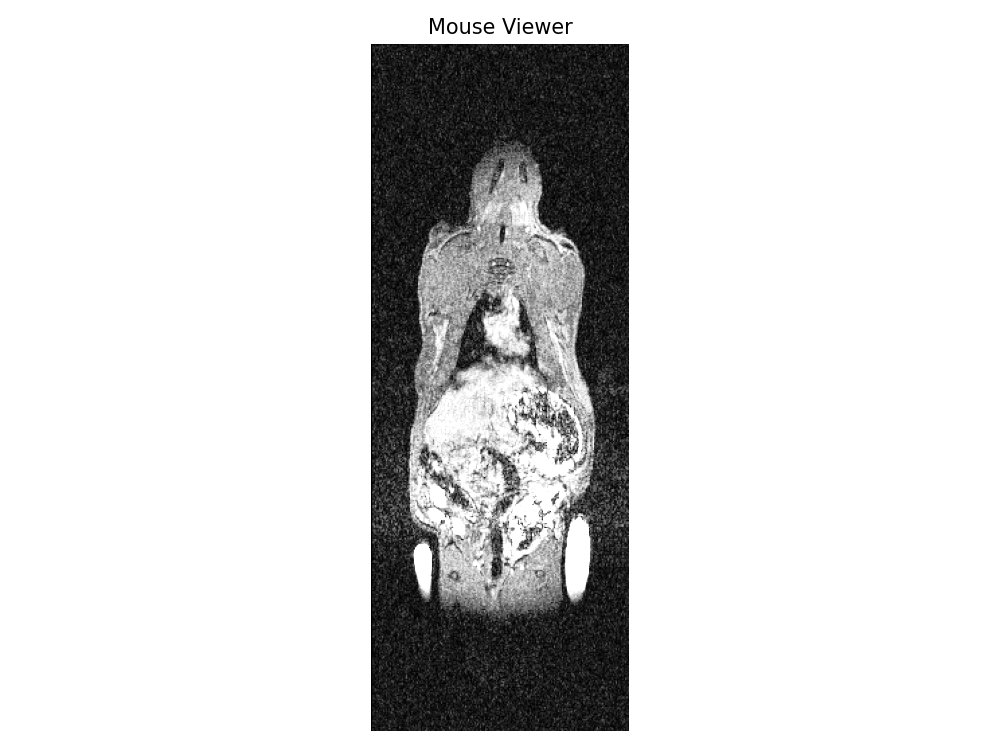

In [5]:
gui.MultiImageDisplay(image_list=[original_image], title_list=['Mouse Viewer'], figure_size=(8,6))

## Filter Images

In [6]:
#!mkdir filter_images

In [7]:
def save_dicom_file(original_file, new_array, file_path):

    original_file.file_meta.TransferSyntaxUID = ExplicitVRLittleEndian
    original_file.PixelData = new_array.tobytes()
    original_file.save_as(file_path)

In [8]:
def intensity_filter(pixel_array, value=75):
    pixel_array = np.array(pixel_array)
    pixel_array[pixel_array<=value] = 0
    return pixel_array

def noise_filter(img):
    img = np.array(img)
    w = np.ones([5,5])/25
    Im_filter = ndimage.convolve(img,w, mode='reflect')
    return Im_filter

def erosion(img):
    kernel = np.ones((5,5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=1)
    
    return img_erosion

def dilatation(img):
    kernel = np.ones((10,10), np.uint8)
    img_dilation = cv2.dilate(img, kernel, iterations=1)
    return img_dilation

def binarize_image(pixel_array, threshold=75):
    pixel_array = np.array(pixel_array)
    pixel_array[pixel_array<=threshold] = 0
    pixel_array[pixel_array>threshold] = 1
    return pixel_array

def smooth_edges(img):
    img = np.array(img, np.uint8)
    img = Image.fromarray(img, 'L')
    img = img.filter(ImageFilter.ModeFilter(size=13))
    return img

In [27]:
filter_path = "filter_images/"

for file in os.listdir(path):
    f = os.path.join(path, file)
    # checking if it is a file
    if os.path.isfile(f):
        ds = dcmread(f)
        filtered_image = intensity_filter(ds.pixel_array)
        filtered_image = noise_filter(filtered_image)
        filtered_image = dilatation(filtered_image)
        filtered_image = erosion(filtered_image)
        
        save_dicom_file(ds, filtered_image, os.path.join(filter_path, file))

In [28]:
ds.Modality

'MR'

In [29]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(filter_path)
reader.SetFileNames(dicom_names)
filtered_image = reader.Execute()

size = filtered_image.GetSize()
size

(192, 512, 120)

<IPython.core.display.Javascript object>


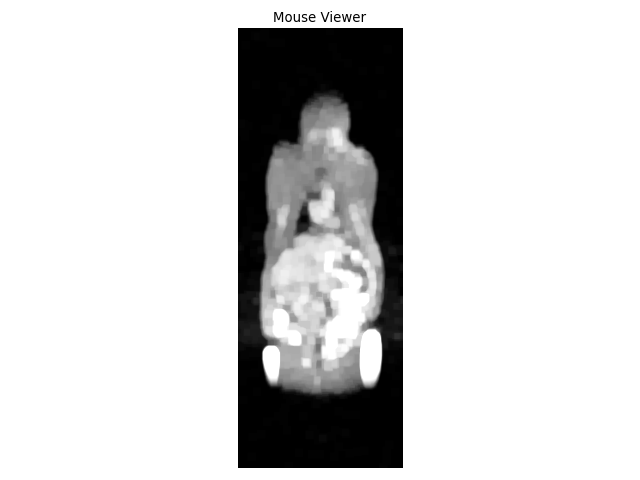

In [30]:
gui.MultiImageDisplay(image_list=[filtered_image], title_list=['Mouse Viewer'], figure_size=(8,6))

In [13]:
#!mkdir binary_images

In [14]:
binary_path = "binary_images/"

for file in os.listdir(filter_path):
    f = os.path.join(filter_path, file)
    # checking if it is a file
    if os.path.isfile(f):
        ds = dcmread(f)
        filtered_image = binarize_image(ds.pixel_array)
        #filtered_image = smooth_edges(filtered_image)
        
        save_dicom_file(ds, filtered_image, os.path.join(binary_path, file))

In [15]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(binary_path)
reader.SetFileNames(dicom_names)
binary_image = reader.Execute()

size = binary_image.GetSize()
size

(192, 512, 120)

<IPython.core.display.Javascript object>


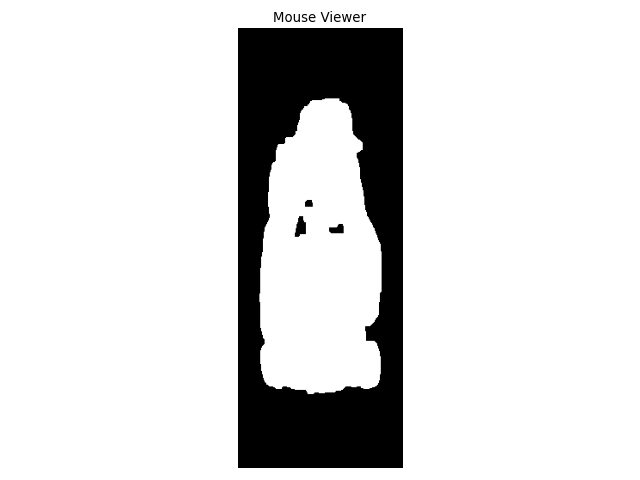

In [16]:
gui.MultiImageDisplay(image_list=[binary_image], title_list=['Mouse Viewer'], figure_size=(8,6))

# Binary 3D model

In [19]:
sitk.WriteImage(binary_image, "mouse_binary.nii.gz")

In [20]:
#Set limits to x and y for a good view
mouse = sitk.ReadImage("mouse_binary.nii.gz")
itkwidgets.view(mouse)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

In [21]:
!python dicom2stl/dicom2stl.py -i 90 -o mouse_binary.stl mouse_binary.nii.gz


Temp dir: Not specified, will use system temporary directory
Isovalue =  90.0
File names:  ['mouse_binary.nii.gz'] 


2021-08-09 19:19:52.511 (   2.744s) [                ]vtkPolyDataConnectivity:104    ERR| vtkPolyDataConnectivityFilter (000002539908D590): No points!
2021-08-09 19:19:52.584 (   2.818s) [                ]vtkPolyDataConnectivity:104    ERR| vtkPolyDataConnectivityFilter (000002539908D590): No points!
2021-08-09 19:19:52.629 (   2.862s) [                ]vtkWindowedSincPolyData:108    ERR| vtkWindowedSincPolyDataFilter (00000253986CA830): No data to smooth!
2021-08-09 19:19:52.684 (   2.917s) [                ]     vtkDecimatePro.cxx:160    ERR| vtkDecimatePro (000002539B6A45A0): No data to decimate!
2021-08-09 19:19:52.743 (   2.976s) [                ]       vtkSTLWriter.cxx:77     ERR| vtkSTLWriter (000002539905E2B0): No data to write!



Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.048 seconds
Surface extracted
     0 polygons
     0.182 seconds
Surface cleaned
     0 polygons
     0.002 seconds
Small parts cleaned
     0 polygons
     0.08 seconds
Surface smoothed
     0 polygons
     0.014 seconds
Surface reduced
     0 polygons
     0.013000000000000001 seconds
Writing 0 polygons to mouse_binary.stl
writeSTL 1
Output mesh: mouse_binary.stl



In [22]:
mesh = vtkutils.readMesh('mouse_binary.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse_binary.stl


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [23]:
!python dicom2stl/dicom2stl.py --help

usage: dicom2stl.py [-h] [--verbose] [--debug] [--output OUTPUT] [--meta META]
                    [--ct] [--clean] [--temp TEMP] [--search SEARCH]
                    [--type {skin,bone,soft_tissue,fat}] [--anisotropic]
                    [--isovalue ISOVALUE] [--double DOUBLE_THRESHOLD]
                    [--largest] [--rotaxis {X,Y,Z}] [--rotangle ROTANGLE]
                    [--smooth SMOOTH] [--reduce REDUCE] [--clean-small SMALL]
                    [--enable {anisotropic,shrink,median,largest,rotation}]
                    [--disable {anisotropic,shrink,median,largest,rotation}]
                    [filenames [filenames ...]]

positional arguments:
  filenames

optional arguments:
  -h, --help            show this help message and exit
  --verbose, -v         Enable verbose messages
  --debug, -D           Enable debugging messages
  --output OUTPUT, -o OUTPUT
                        Output file name (default=result.stl)
  --meta META, -m META  Output metadata file
  --ct    

In [24]:
!python dicom2stl/dicom2stl.py -a -i 90 -t soft_tissue -l --smooth 100 --reduce 0.6 -x 0.1 -o mouse_binary_2.stl mouse_binary.nii.gz

2021-08-09 19:20:10.294 (  12.692s) [                ]vtkPolyDataConnectivity:104    ERR| vtkPolyDataConnectivityFilter (0000016407732D70): No points!
2021-08-09 19:20:10.369 (  12.767s) [                ]vtkPolyDataConnectivity:104    ERR| vtkPolyDataConnectivityFilter (0000016407732D70): No points!
2021-08-09 19:20:10.418 (  12.816s) [                ]vtkWindowedSincPolyData:108    ERR| vtkWindowedSincPolyDataFilter (0000016406DBC440): No data to smooth!
2021-08-09 19:20:10.507 (  12.905s) [                ]     vtkDecimatePro.cxx:160    ERR| vtkDecimatePro (0000016409D09710): No data to decimate!
2021-08-09 19:20:10.600 (  12.999s) [                ]       vtkSTLWriter.cxx:77     ERR| vtkSTLWriter (00000164076B37A0): No data to write!



Temp dir: Not specified, will use system temporary directory
Tissue type:  soft_tissue
Isovalue =  90.0
File names:  ['mouse_binary.nii.gz'] 

Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.032 seconds
Anisotropic Smoothing
     8.658 seconds
Median filter
     -26.751 seconds
Surface extracted
     0 polygons
     0.339 seconds
Surface cleaned
     0 polygons
     0.002 seconds
Small parts cleaned
     0 polygons
     0.083 seconds
Surface smoothed
     0 polygons
     0.02 seconds
Surface reduced
     0 polygons
     0.017 seconds
Writing 0 polygons to mouse_binary_2.stl
writeSTL 1
Output mesh: mouse_binary_2.stl



In [25]:
mesh = vtkutils.readMesh('mouse_binary_2.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse_binary_2.stl


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Filtered 3D model

In [31]:
sitk.WriteImage(filtered_image, "mouse_filtered.nii.gz")

In [32]:
#Set limits to x and y for a good view
mouse = sitk.ReadImage("mouse_filtered.nii.gz")
itkwidgets.view(mouse)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

In [33]:
!python dicom2stl/dicom2stl.py -i 90 -o mouse_filtered.stl mouse_filtered.nii.gz


Temp dir: Not specified, will use system temporary directory
Isovalue =  90.0
File names:  ['mouse_filtered.nii.gz'] 

Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.018000000000000002 seconds
Surface extracted
     224376 polygons
     0.168 seconds
Surface cleaned
     224376 polygons
     0.106 seconds
Small parts cleaned
     205940 polygons
     0.187 seconds
Surface smoothed
     205940 polygons
     0.969 seconds
Surface reduced
     20593 polygons
     2.68 seconds
Writing 20593 polygons to mouse_filtered.stl
writeSTL 1
Output mesh: mouse_filtered.stl



In [34]:
mesh = vtkutils.readMesh('mouse_filtered.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse_filtered.stl


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [35]:
!python dicom2stl/dicom2stl.py --help

usage: dicom2stl.py [-h] [--verbose] [--debug] [--output OUTPUT] [--meta META]
                    [--ct] [--clean] [--temp TEMP] [--search SEARCH]
                    [--type {skin,bone,soft_tissue,fat}] [--anisotropic]
                    [--isovalue ISOVALUE] [--double DOUBLE_THRESHOLD]
                    [--largest] [--rotaxis {X,Y,Z}] [--rotangle ROTANGLE]
                    [--smooth SMOOTH] [--reduce REDUCE] [--clean-small SMALL]
                    [--enable {anisotropic,shrink,median,largest,rotation}]
                    [--disable {anisotropic,shrink,median,largest,rotation}]
                    [filenames [filenames ...]]

positional arguments:
  filenames

optional arguments:
  -h, --help            show this help message and exit
  --verbose, -v         Enable verbose messages
  --debug, -D           Enable debugging messages
  --output OUTPUT, -o OUTPUT
                        Output file name (default=result.stl)
  --meta META, -m META  Output metadata file
  --ct    

In [36]:
!python dicom2stl/dicom2stl.py -a -i 70  -t soft_tissue -l --smooth 50 --reduce .1 -x 0.1 -o mouse_filtered_2.stl mouse_filtered.nii.gz


Temp dir: Not specified, will use system temporary directory
Tissue type:  soft_tissue
Isovalue =  70.0
File names:  ['mouse_filtered.nii.gz'] 

Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.023 seconds
Anisotropic Smoothing
     10.335 seconds
Median filter
     -27.44 seconds
Surface extracted
     191566 polygons
     0.263 seconds
Surface cleaned
     184258 polygons
     0.23800000000000002 seconds
Small parts cleaned
     184258 polygons
     0.23500000000000001 seconds
Surface smoothed
     184258 polygons
     1.682 seconds
Surface reduced
     165832 polygons
     0.47100000000000003 seconds
Writing 165832 polygons to mouse_filtered_2.stl
writeSTL 1
Output mesh: mouse_filtered_2.stl



In [37]:
mesh = vtkutils.readMesh('mouse_filtered_2.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse_filtered_2.stl


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## Edge Detection Filtering

# !mkdir edge_filter

In [ ]:
def apply_edge_filter(pixel_array, adjust_value=0.00064, filter_type="prewitt"):
    if filter_type == "prewitt":
        out = prewitt(pixel_array)
    elif filter_type == "roberts":
        out = roberts(pixel_array)
    elif filter_type == "sobel":
        out = sobel(pixel_array)
    elif filter_type == "scharr":
        out = scharr(pixel_array)
        
    out = out > adjust_value
    out = out.astype(np.uint16)
    return out

In [ ]:
new_path = "edge_filter/"

for file in os.listdir(path):
    f = os.path.join(path, file)
    # checking if it is a file
    if os.path.isfile(f):
        ds = dcmread(f)
        filtered_image = apply_edge_filter(ds.pixel_array)
        save_dicom_file(ds, filtered_image, os.path.join(new_path, file))

In [ ]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(new_path)
reader.SetFileNames(dicom_names)
image = reader.Execute()

size = image.GetSize()
size

In [ ]:
gui.MultiImageDisplay(image_list=[image], title_list=['Mouse Viewer'], figure_size=(8,6))

In [ ]:
sitk.WriteImage(image, "mouse_filtered.nii.gz")

In [ ]:
#Set limits to x and y for a good view
mouse = sitk.ReadImage("mouse_filtered.nii.gz")
itkwidgets.view(mouse)

In [ ]:
!python dicom2stl/dicom2stl.py -i 1000 -o mouse_filtered.stl mouse_filtered.nii.gz

In [ ]:
mesh = vtkutils.readMesh('mouse_filtered.stl')
itkwidgets.view(mesh, geometries=[mesh])

In [ ]:
!python dicom2stl/dicom2stl.py --help

In [ ]:
!python dicom2stl/dicom2stl.py -a -i 90 -t soft_tissue -l --smooth 100 --reduce 0.6 -x 0.1 -o mouse_filtered_2.stl mouse_filtered_2.nii.gz

In [ ]:
mesh = vtkutils.readMesh('mouse_filtered_2.stl')
itkwidgets.view(mesh, geometries=[mesh])